# 0. Imports

In [23]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Supressing warnings
import warnings
warnings.filterwarnings('ignore')


# 1. Loading and Plotting Images

In [24]:
def load_player_images(image_dir, prefix='player', max_images=30):
    """
    Load images that start with 'player' from the specified directory into a list.
    
    Parameters:
    image_dir (str): The directory to load images from.
    max_images (int): Maximum number of images to load.
    prefix (str): Prefix of image file names

    Returns:
    List of images loaded using OpenCV.
    """
    image_files = [f for f in os.listdir(image_dir) if f.startswith(prefix) and 
                   os.path.splitext(f)[1].lower() in ['.jpg', '.jpeg', '.png']]
    image_files = image_files[:max_images]  # Limit to max_images
    
    images = []
    for img_file in image_files:
        img_path = os.path.join(image_dir, img_file)
        img = cv2.imread(img_path)  # Load the image using OpenCV
        if img is not None:
            images.append(img)
    
    return images

In [25]:
def plot_images(images, bgr=True, titles=[]):
    """
    Plot a list of images using matplotlib.
    
    Parameters:
    images (list): List of images (in BGR format) to plot.
    """
    num_images = len(images)
    
    if num_images==0:
        print("There are no images to plot")
        return
    
    cols = 5
    rows = num_images // cols + (0 if num_images//cols == num_images/cols else 1)
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*2))
    axes = axes.flatten()

    for i, img in enumerate(images):
        if bgr:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for plotting
        axes[i].imshow(img)
        axes[i].axis('off')
        if titles and i < len(titles):
            axes[i].set_title(titles[i])

    # Hide any remaining axes if less than rows*cols
    for i in range(len(images), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

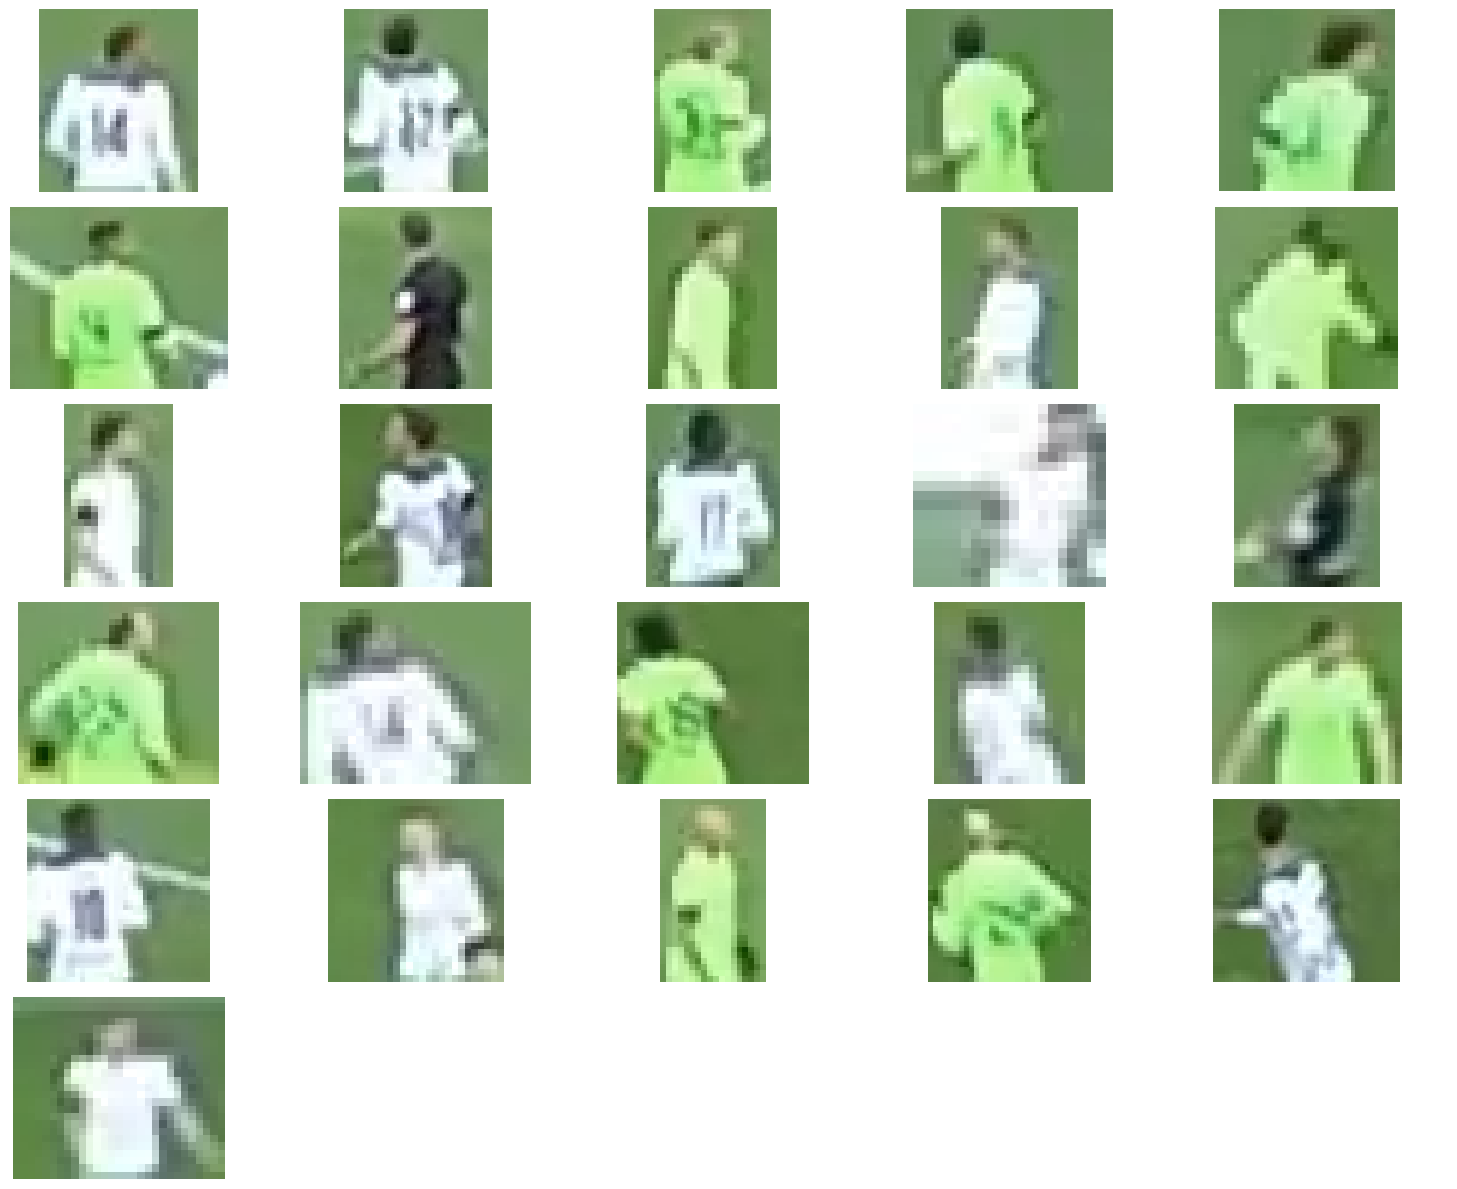

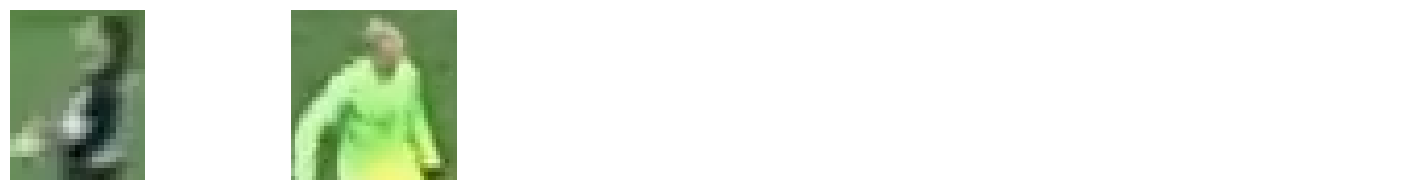

In [26]:
IMG_DIR = '../output_videos'

# Load images
player_imgs = load_player_images(IMG_DIR)
goalkeeper_imgs = load_player_images(IMG_DIR, prefix='goalkeeper')

# Plot images
plot_images(player_imgs)

plot_images(goalkeeper_imgs)


# 2. Masking

In [27]:
def apply_mask(images=[], green_threshold=.08):
    """
    Apply a mask to images based on green color in HSV space. 
    If the mask covers more than 25% of the image, apply the inverse of the mask.

    Parameters:
    images (list): List of images to apply the mask on.

    Returns:
    List of masked images.
    """
    masked_images = []

    for image in images:
        hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # Define the green color range in HSV
        lower_green = np.array([36, 25, 25])
        upper_green = np.array([86, 255, 255])

        # Create the mask
        mask = cv2.inRange(hsv_img, lower_green, upper_green)

        # Count the number of masked pixels
        total_pixels = image.shape[0] * image.shape[1]
        masked_pixels = cv2.countNonZero(cv2.bitwise_not(mask))
        mask_percentage = masked_pixels / total_pixels
        
        if mask_percentage > green_threshold:
            # Apply inverse mask
            masked_img = cv2.bitwise_and(image, image, mask=cv2.bitwise_not(mask))
        else:
            # Apply normal mask
            masked_img = image

        masked_images.append(masked_img)

    return masked_images

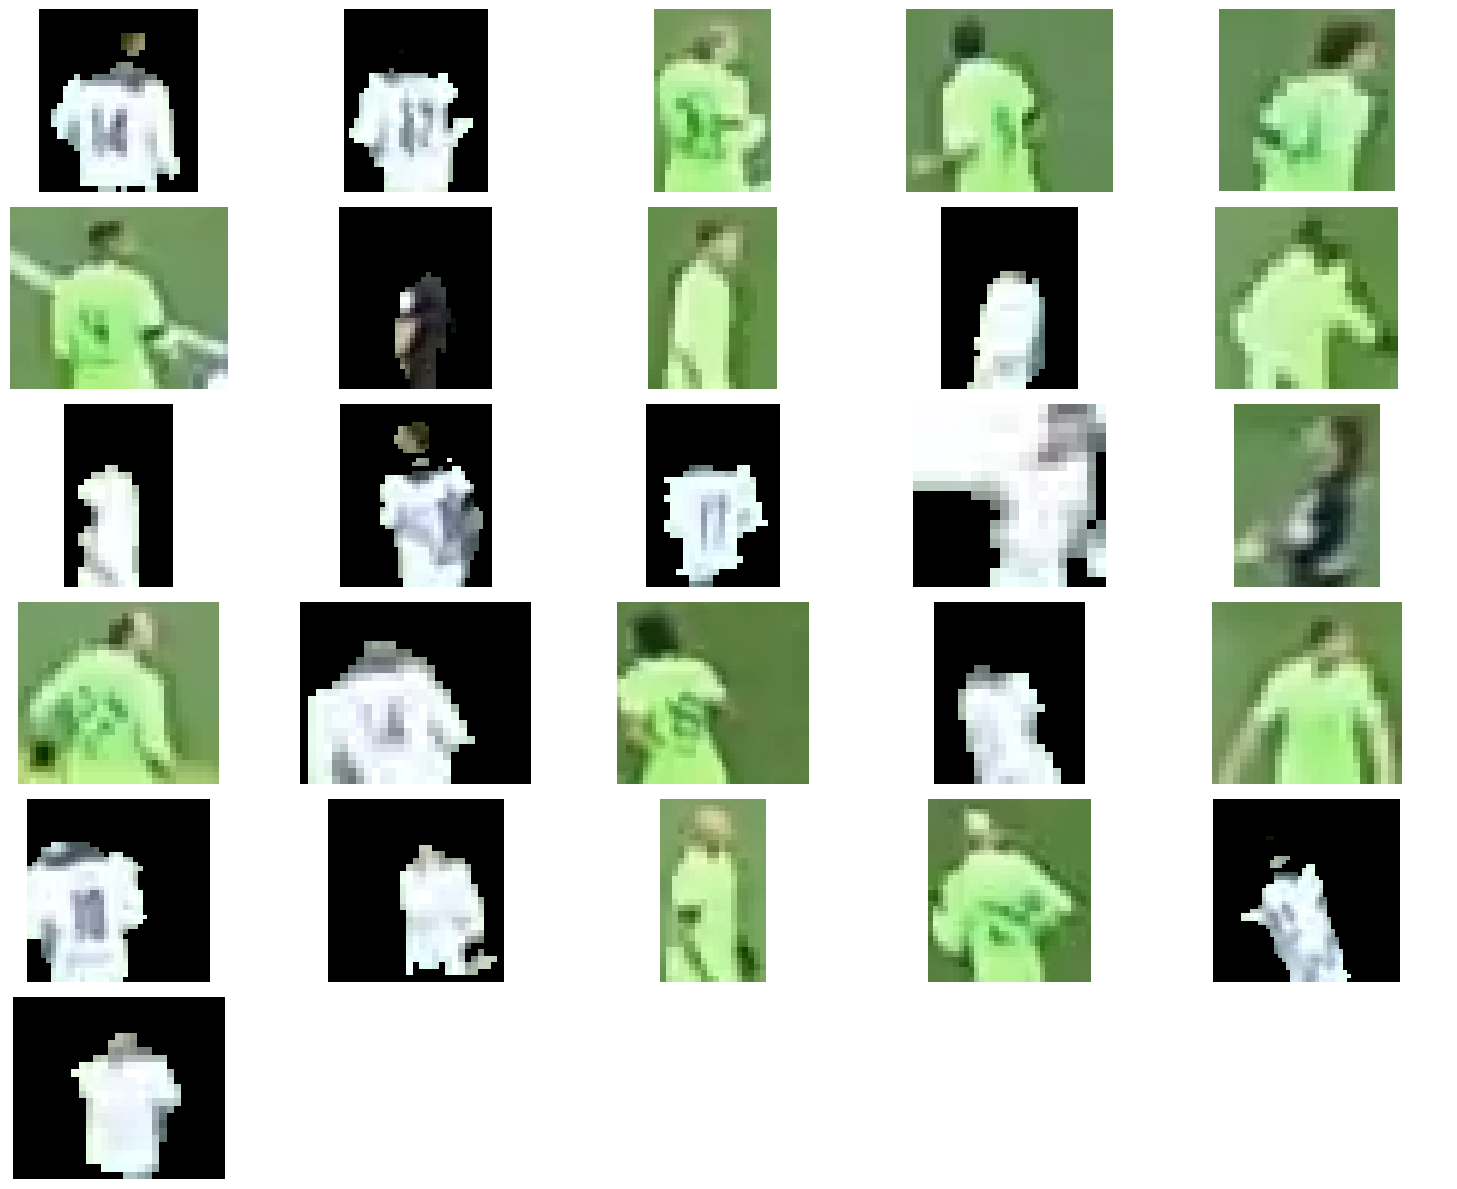

In [28]:
masked_player_imgs = apply_mask(player_imgs)

plot_images(masked_player_imgs)

# 3. Clustering

In [29]:
def clustering(kmeans, images=[]):
    cluster_imgs = []
    
    for img in images:
        # Reshape image to 2D array
        img_reshape = img.reshape(-1, 3)
        
        # K-Means clustering
        kmeans.fit(img_reshape)
        
        # Get Cluster Labels
        labels = kmeans.labels_
        
        # Get the colors of the clusters
        colors = kmeans.cluster_centers_

        # Create an image with the clustered colors
        clustered_image = labels.reshape(img.shape[0], img.shape[1])
        
        # Most frequent cluster of the corners should be the background cluster
        corners = [clustered_image[0, 0], clustered_image[0, -1], clustered_image[-1, 0], clustered_image[-1, -1]]
        bg_cluster = max(set(corners), key=corners.count)

        # The other cluster is a player cluster
        player_cluster = 1-bg_cluster

        jersey_color = kmeans.cluster_centers_[player_cluster]

        jersey_color = (jersey_color[2], jersey_color[1], jersey_color[0])
        cluster_imgs.append([[tuple([x / 255. for x in jersey_color])]])

    return cluster_imgs


def apply_colors(color_imgs=[], color1=(0,0,0), color2=(255,255,255)):
    centroids = np.array([color1, color2])
    teams = []
    for img in color_imgs:
        print(img)
        print(centroids/255.)
        distances = np.linalg.norm(img[0] - centroids/255., axis=1)
        print(distances)
        teams.append(np.argmin(distances))
    return teams

In [30]:
def apply_colors(color_imgs=[], color1=(0,0,0), color2=(255,255,255)):
    """
    Assign colors to teams based on LAB color space distance.
    
    Parameters:
    color_imgs (list): List of RGB color arrays to classify
    color1 (tuple): RGB values for the first team color
    color2 (tuple): RGB values for the second team color
    
    Returns:
    list: Team assignments (0 or 1) for each input color.
    """
    centroids = np.array([color1, color2])

    teams = []
    for img in color_imgs:
        rgb_img = np.uint8([[np.array(img[0][0]) * 255]])  # Multiply by 255 and convert to uint8
        
        # Calculate distances
        distances = np.linalg.norm(rgb_img[0][0] - centroids, axis=1)
        teams.append(np.argmin(distances))
    
    return teams

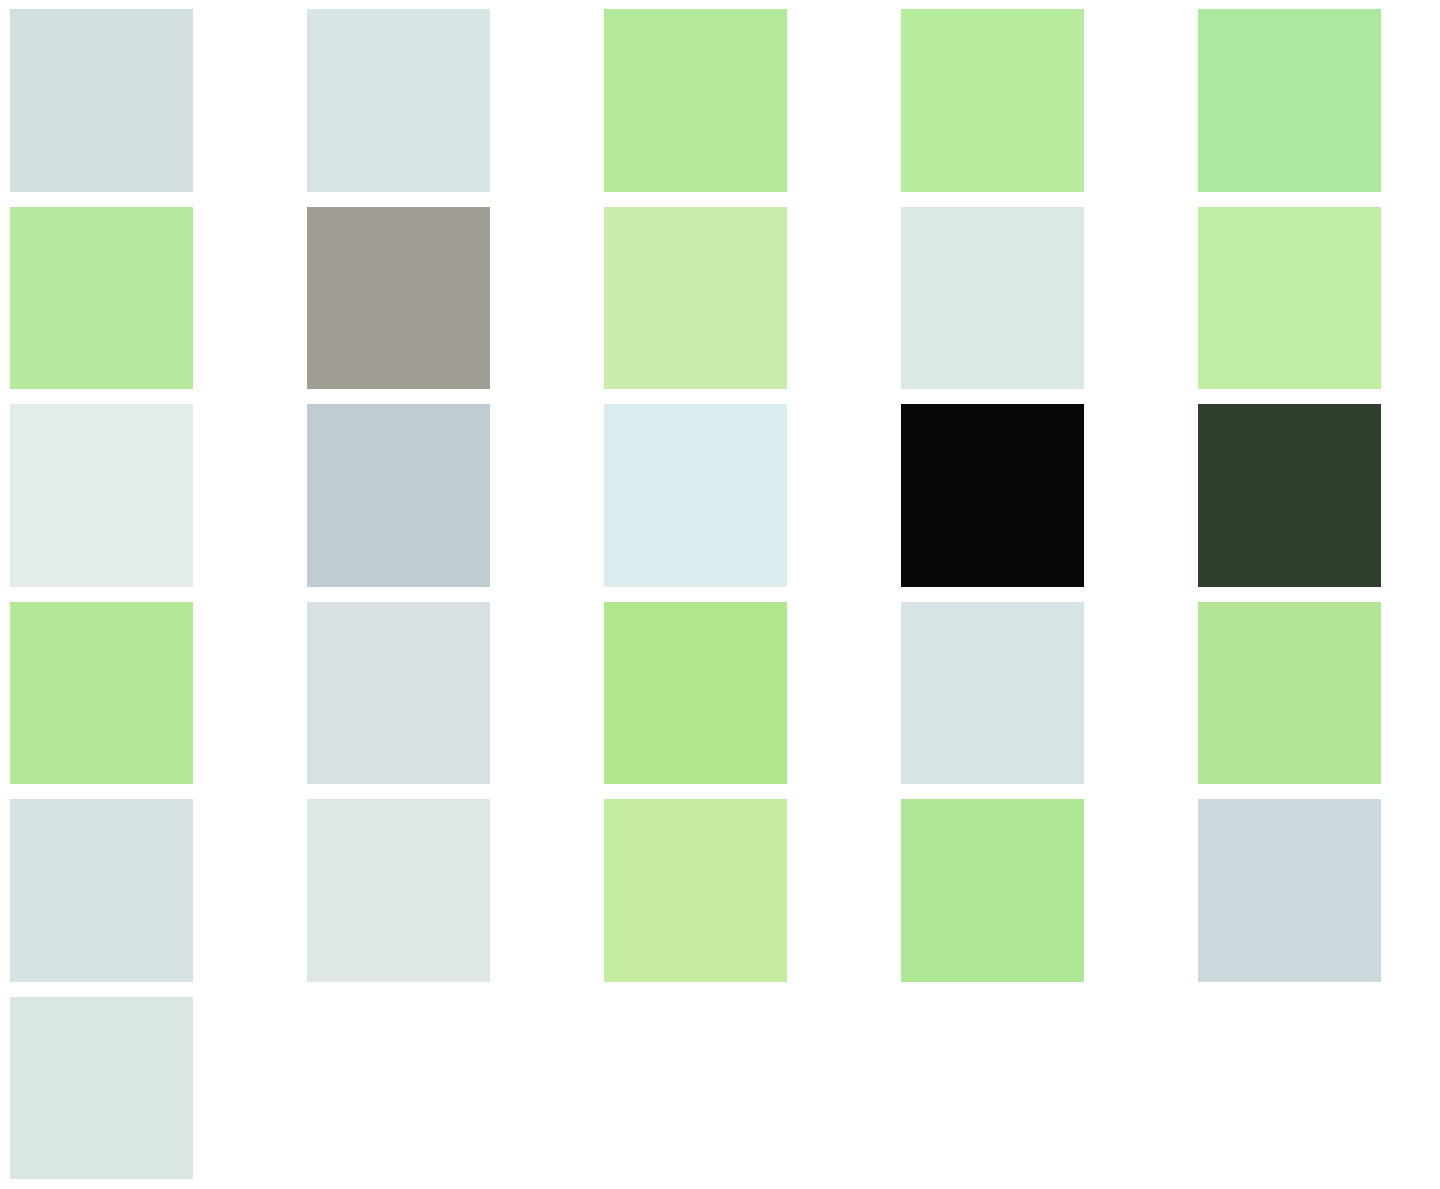

In [31]:
kmeans = KMeans(n_clusters=2, init='k-means++', n_init=10, random_state=42)

clustered_player_imgs = clustering(kmeans, masked_player_imgs)

plot_images(clustered_player_imgs, bgr=False)

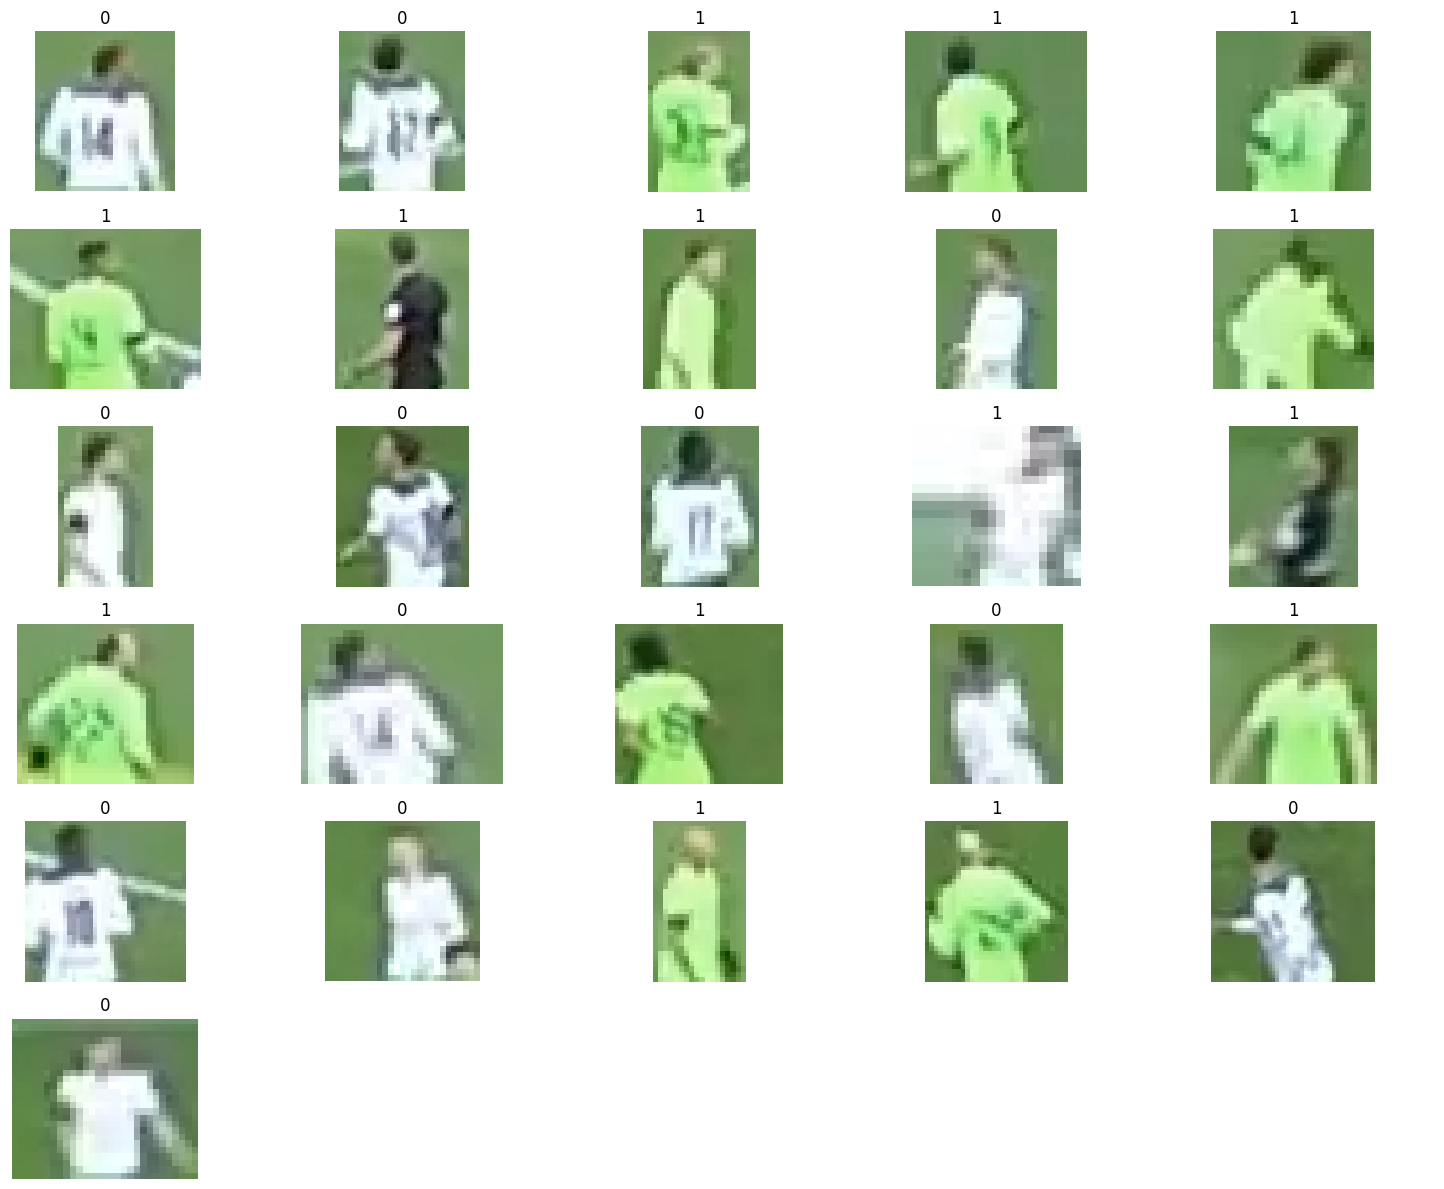

In [32]:
titles = apply_colors(clustered_player_imgs, color1=(232, 247, 248), color2=(172, 251, 145))
plot_images(player_imgs, titles=titles)

# 4. Goalkeeper class testing

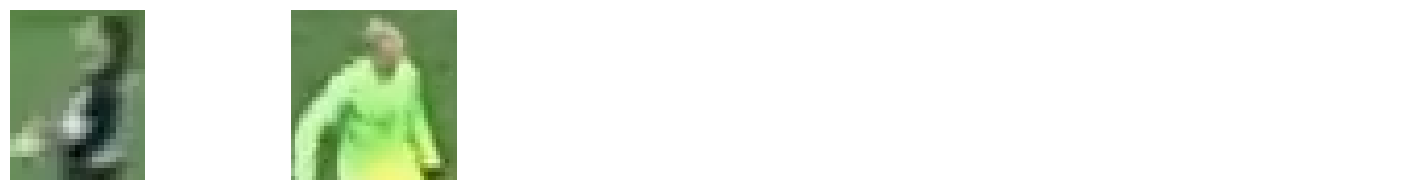

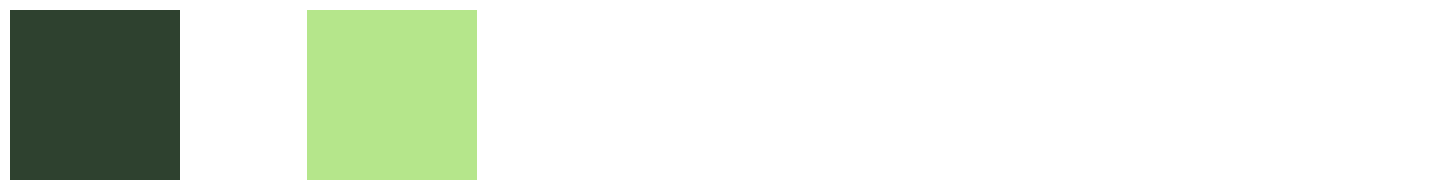

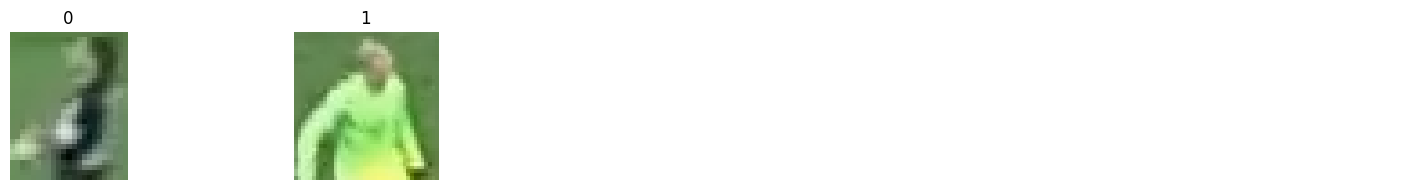

In [33]:
masked_goalkeeper_imgs = apply_mask(goalkeeper_imgs)
plot_images(masked_goalkeeper_imgs)

clustered_goalkeeper_imgs = clustering(kmeans, masked_goalkeeper_imgs)
plot_images(clustered_goalkeeper_imgs, bgr=False)

plot_images(masked_goalkeeper_imgs, titles=apply_colors(clustered_goalkeeper_imgs, color1=(0, 0, 0), color2=(239, 156, 132)))